# Basic CNN

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [6]:
annotations = pd.read_csv('data/annotations.csv')


images = []
labels = []


for _, row in annotations.iterrows():
    img_path = f'data/images/{row["Image"]}'
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))  
    images.append(img)
 
    label = 1 if row['Annotation'] == 'y' else 0
    labels.append(label)


images = np.array(images)
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Add more layers as needed
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


model.save('models/checkbox_classifier.h5')

2023-11-27 17:11:39.974122: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-27 17:11:40.101663: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/10
38/38 [==============================] - 6s 131ms/step - loss: 376.1982 - accuracy: 0.6683 - val_loss: 185.5836 - val_accuracy: 0.2640
Epoch 2/10
38/38 [==============================] - 4s 116ms/step - loss: 6.1752 - accuracy: 0.7006 - val_loss: 0.6806 - val_accuracy: 0.7360
Epoch 3/10
38/38 [==============================] - 4s 113ms/step - loss: 0.6788 - accuracy: 0.7171 - val_loss: 0.6745 - val_accuracy: 0.7360
Epoch 4/10
38/38 [==============================] - 4s 114ms/step - loss: 0.6734 - accuracy: 0.7171 - val_loss: 0.6685 - val_accuracy: 0.7360
Epoch 5/10
38/38 [==============================] - 4s 119ms/step - loss: 0.6680 - accuracy: 0.7171 - val_loss: 0.6628 - val_accuracy: 0.7360
Epoch 6/10
38/38 [==============================] - 4s 117ms/step - loss: 0.6629 - accuracy: 0.7171 - val_loss: 0.6571 - val_accuracy: 0.7360
Epoch 7/10
38/38 [==============================] - 4s 117ms/step - loss: 0.6579 - accuracy: 0.7171 - val_loss: 0.6516 - val_accuracy: 0.7360
Ep

/home/benchovski/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('models/checkbox_classifier.h5')

# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

10/10 [==============================] - 0s 22ms/step - loss: 0.6370 - accuracy: 0.7360
Test Accuracy: 73.60%


10/10 [==============================] - 0s 20ms/step


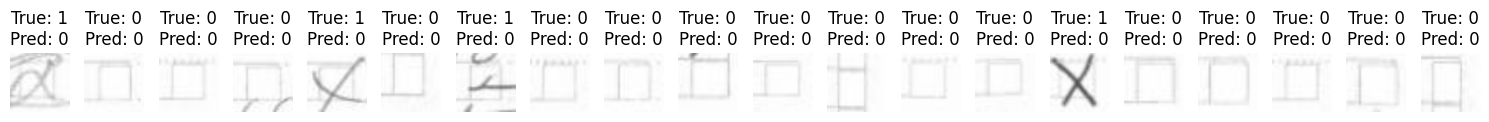

In [13]:
import matplotlib.pyplot as plt

def visualize_predictions(X, y_true, y_pred, num_samples=10):
    """
    Visualize a sample of test images along with true and predicted labels.

    Parameters:
    X (numpy.array): The test images.
    y_true (numpy.array): The true labels for the test images.
    y_pred (numpy.array): The predicted labels for the test images.
    num_samples (int): Number of samples to visualize.
    """
    # Randomly select 'num_samples' images
    indices = np.random.choice(range(len(X)), num_samples, replace=False)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X[idx])
        plt.title(f"True: {y_true[idx]}\nPred: {y_pred[idx]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Predict on the test set
y_pred = model.predict(X_test)
y_pred = [1 if pred > 0.45 else 0 for pred in y_pred]  # Convert probabilities to class labels

# Visualize predictions
visualize_predictions(X_test, y_test, y_pred, num_samples=20)


# VGG16

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
annotations = pd.read_csv('data/annotations.csv')

images = []
labels = []

for _, row in annotations.iterrows():
    img = cv2.imread(f'data/images/{row["Image"]}')
    img = cv2.resize(img, (224, 224))  # Resize to fit VGG16 input
    images.append(img)
    label = 1 if row['Annotation'] == 'y' else 0
    labels.append(label)

images = np.array(images)
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

In [19]:
# Load VGG16 pre-trained on ImageNet data
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top for our binary classification problem
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_generator, epochs=10, validation_data=(X_test, y_test))

58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/10
38/38 [==============================] - 149s 4s/step - loss: 1.2855 - accuracy: 0.9603 - val_loss: 0.7753 - val_accuracy: 0.9901
Epoch 2/10
38/38 [==============================] - 152s 4s/step - loss: 1.4873 - accuracy: 0.9835 - val_loss: 1.7011 - val_accuracy: 0.9868
Epoch 3/10
38/38 [==============================] - 152s 4s/step - loss: 1.1209 - accuracy: 0.9859 - val_loss: 0.1956 - val_accuracy: 0.9967
Epoch 4/10
38/38 [==============================] - 152s 4s/step - loss: 1.2945 - accuracy: 0.9843 - val_loss: 0.4971 - val_accuracy: 0.9802
Epoch 5/10
38/38 [==============================] - 155s 4s/step - loss: 0.7771 - accuracy: 0.9876 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 6/10
38/38 [==============================] - 152s 4s/step - loss: 0.7243 - accuracy: 0.9859 - val_loss: 0.1881 - val_accuracy: 0.9967
Epoch 7/10
38/38 [==============================] - 156s 4s/step - loss: 0.8025 - accurac

10/10 [==============================] - 27s 3s/step
[[218   0]
 [  3  82]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       218
           1       1.00      0.96      0.98        85

    accuracy                           0.99       303
   macro avg       0.99      0.98      0.99       303
weighted avg       0.99      0.99      0.99       303



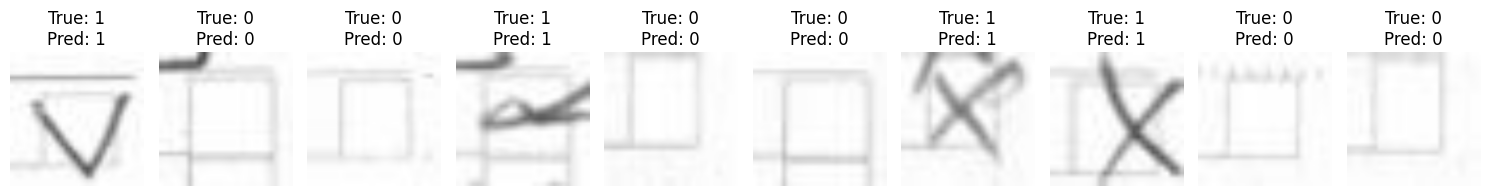

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
y_pred = model.predict(X_test)
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Classification Report
print(classification_report(y_test, y_pred))

# Visualization of Predictions
def visualize_predictions(X, y_true, y_pred, num_samples=10):
    indices = np.random.choice(range(len(X)), num_samples, replace=False)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X[idx])
        plt.title(f"True: {y_true[idx]}\nPred: {y_pred[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(X_test, y_test, y_pred, num_samples=10)


In [21]:
model.save('models/checkbox_classifier_vgg16.h5')


/home/benchovski/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
model.save('models/checkbox_classifier_vgg16.keras')
